In [57]:
import transformers 
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns


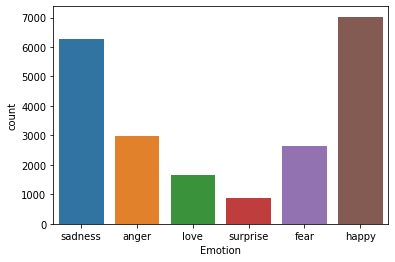

In [58]:
df = pd.read_csv("Emotion_final.csv")
sns.countplot(df.Emotion)

In [59]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Emotion"] = label_encoder.fit_transform(df["Emotion"])
print(df)

                                                    Text  Emotion
0                                i didnt feel humiliated        4
1      i can go from feeling so hopeless to so damned...        4
2       im grabbing a minute to post i feel greedy wrong        0
3      i am ever feeling nostalgic about the fireplac...        3
4                                   i am feeling grouchy        0
...                                                  ...      ...
21454               Melissa stared at her friend in dism        1
21455  Successive state elections have seen the gover...        1
21456               Vincent was irritated but not dismay        1
21457  Kendall-Hume turned back to face the dismayed ...        1
21458                    I am dismayed , but not surpris        1

[21459 rows x 2 columns]


In [60]:
print("SHAPE::",df.shape)

SHAPE:: (21459, 2)


In [61]:
class_name = ['sadness','anger','love','surprise','fear','happy']

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [63]:
device

device(type='cpu')

In [64]:
PRE_TRAINED_MODEL_NAME = 'roberta-base'

In [65]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [66]:
roberta_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████████████████████████████████████████████████████████████████████| 21459/21459 [00:10<00:00, 2083.79it/s]


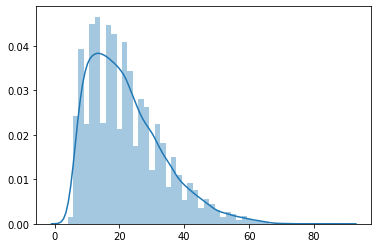

In [67]:
from tqdm import tqdm
token_lens = []
for txt in tqdm(df.Text):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens)

In [68]:
from torch.utils.data import Dataset, DataLoader
class ReviewDataset(Dataset):
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

In [69]:
size=len(df)
df_test = df[0:int(size/8)]
df_val = df[int(size/8):int(size/4)]
df_train = df[int(size/4):size]

In [70]:
df_train.shape, df_val.shape, df_test.shape


((16095, 2), (2682, 2), (2682, 2))

In [71]:
print(df)

                                                    Text  Emotion
0                                i didnt feel humiliated        4
1      i can go from feeling so hopeless to so damned...        4
2       im grabbing a minute to post i feel greedy wrong        0
3      i am ever feeling nostalgic about the fireplac...        3
4                                   i am feeling grouchy        0
...                                                  ...      ...
21454               Melissa stared at her friend in dism        1
21455  Successive state elections have seen the gover...        1
21456               Vincent was irritated but not dismay        1
21457  Kendall-Hume turned back to face the dismayed ...        1
21458                    I am dismayed , but not surpris        1

[21459 rows x 2 columns]


In [72]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train.Emotion.values),
                                                 df_train.Emotion.values)

In [73]:
class_weights

array([1.17550394, 1.32273176, 0.51586538, 2.21145919, 0.56917038,
       4.07056146])

In [74]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = ReviewDataset(
        reviews = df.Text.to_numpy(), 
        targets = df.Emotion.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=0)

In [75]:
MAX_LEN=10
BATCH_SIZE = 5
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [82]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.4)
        #self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
        self.out1 = nn.Linear(self.roberta.config.hidden_size, 128)
        self.drop1 = nn.Dropout(p=0.4)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, n_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.roberta(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #output = self.relu(pooled_output)
        hidden_state = pooled_output[0]
        output = hidden_state[:,0]
        output = self.drop(output)
        output = self.out1(output)
        output = self.relu(output)
        output = self.drop1(output)
        return self.out(output)

In [83]:
model = SentimentClassifier(len(class_name))
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [84]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
#class_weights = torch.FloatTensor(class_weights).to(device)
#weight=class_weights
loss_fn = nn.CrossEntropyLoss().to(device)

In [85]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    print(data_loader)
    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [86]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
      model = model.eval()
      losses = []
      correct_predictions = 0
      with torch.no_grad():
        for d in data_loader:
          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)
          targets = d["targets"].to(device)
          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)
          loss = loss_fn(outputs, targets)
          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())
      return correct_predictions.double() / n_examples, np.mean(losses)

In [87]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 1.5622463270726157 accuracy 0.34520037278657967
Val   loss 2.4682945516966353 accuracy 0.11819537658463833

Epoch 2/5
----------
Train loss 1.5666412765732478 accuracy 0.3516620068344206
Val   loss 4.250708415743581 accuracy 0.11819537658463833

Epoch 3/5
----------
Train loss 1.542501447409271 accuracy 0.3526561043802423
Val   loss 5.253365407220922 accuracy 0.11819537658463833

Epoch 4/5
----------
Train loss 1.5498020278187783 accuracy 0.35402298850574715
Val   loss 5.166001732566947 accuracy 0.11819537658463833

Epoch 5/5
----------
Train loss 1.5778932396800447 accuracy 0.3419695557626592
Val   loss 1.4602178654857187 accuracy 0.39746457867263235



In [1]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

NameError: name 'history' is not defined

In [2]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

NameError: name 'eval_model' is not defined

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

<div dir="rtl">
اینجا یادم رفت بعد که مدل درست شد ارزیابیش کنم و بعد که یادم افتاد اطلاعات پاک شده بود :).
البته که اینجور که نشون میده دقت بالا نیست.
شاید به خاطر همون مشکل توی مدل برت باشه.
 خلاصه که این هم از حماسه‌آفرینی این قسمت!
</div>